# DRL Course 2023 Домашнее задание 7 #

Отчет по выполнению домашнего задания, Nikita Sorokin

In [2]:
import numpy as np
import random
import torch
import torch.nn as nn
import gym
import time
from tqdm import tqdm
from copy import deepcopy
from torch.distributions import Normal, Categorical

import matplotlib.pyplot as plt
from matplotlib import animation
import seaborn as sns

sns.set()

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 6.0)

In [3]:
def save_frames_as_gif(frames, path='./', filename='gym_animation.gif', fps=60):

    plt.figure(figsize=(frames[0].shape[1] / 50.0, frames[0].shape[0] / 50.0), dpi=72)

    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval=50)
    anim.save(path + filename, writer='imagemagick', fps=fps)

## Сравнение алгоритмов для среды Pendulum-v1

In [4]:
env = gym.make('Pendulum-v1')

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

c:\Users\никита\AppData\Local\Programs\Python\Python311\Lib\site-packages\gym\utils\env_checker.py:200: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) cf https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(


### CEM

Пусть $ \pi^{\theta}: \mathbb{R}^n \rightarrow \mathbb{R}^m $ - нейронная сеть.

В цикле по $ n $ для $ n \in \overline{1, N} $:

* **(Policy evaluation)** В соответствии с политикой

$$
\pi_n (s) = [\pi^{\theta_n} + Noise(\varepsilon)]_A,
$$

получим $ K $ траекторий $ \theta_k $ и награду $ G(\tau_k) $. Оценим матожидание как:

$$
\mathbb{E}_{\pi_n} [G] \approx V_n :=  \frac{1}{K} \sum_{k=1}^{K} G(\tau_k)
$$


* **(Policy improvement)** Выбираем элитные тракектории, как

$$  
T_n = \{\tau_k: k \in \overline{1, K}: G(\tau_k) > \gamma_q \}, \quad
\text{где $ \gamma_q $ - квантиль уровня $ q $}. 
$$

Определяем лосс:

$$
Loss(\theta) = \frac{1}{|T_n|} \sum_{(a|s) \in T_n} || \pi^{\theta_n} (s) - a||^2
$$

Обновляем $ \theta $ градиентным спуском и уменьшаем $ \varepsilon $.

Реализация:



In [ ]:
class CEM_continuous(nn.Module):
    def __init__(self, state_dim, action_dim, min_action, max_action):
        super().__init__()
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.min_action = min_action
        self.max_action = max_action

        self.network = nn.Sequential(
            nn.Linear(self.state_dim, 100),
            nn.ReLU(),
            nn.Linear(100, self.action_dim)
        )

        self.optimizer = torch.optim.Adam(self.parameters(), lr=1e-1, betas=(0.9, 0.999))
        self.loss = nn.MSELoss()

    def forward(self, _input):
        return self.network(_input)

    def get_action(self, state, eps=0, discrete_action=False):
        state = torch.FloatTensor(state)
        self.min_action = torch.FloatTensor([self.min_action])
        self.max_action = torch.FloatTensor([self.max_action])

        noise = torch.randn(self.action_dim)
        noise = 2 if noise > 0 else -2

        with torch.no_grad():
            action = torch.clamp(self.forward(state) + eps * noise,
                                 min=self.min_action, max=self.max_action)
        action = action.detach().numpy()

        if discrete_action == True:
            action = list([2 if action > 0 else -2])

        return action

    def update_policy(self, elite_trajectories):
        elite_states = []
        elite_actions = []
        for trajectory in elite_trajectories:
            elite_states.extend(trajectory['states'])
            elite_actions.extend(trajectory['actions'])
        elite_states = torch.FloatTensor(elite_states)
        elite_actions = torch.FloatTensor(elite_actions)

        loss = self.loss(self.forward(elite_states), elite_actions)
        loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()

In [ ]:
def get_trajectory(env, agent, trajectory_len, eps=0, visualize=False, filename='gym_animation.gif', discrete_action=False):
    trajectory = {'states':[], 'actions': [], 'total_reward': 0}

    state = env.reset()
    trajectory['states'].append(state)

    frames = []
    for i in range(trajectory_len):

        action = agent.get_action(state, eps, discrete_action)
        trajectory['actions'].append(action)

        state, reward, done, _ = env.step(action)
        trajectory['total_reward'] += reward

        if done:
            break

        if visualize:
            frames.append(env.render(mode="rgb_array"))

        if i != trajectory_len - 1:
            trajectory['states'].append(state)

    if visualize:
        save_frames_as_gif(frames, filename=filename)

    return trajectory

def get_elite_trajectories(trajectories, q_param):
    total_rewards = [trajectory['total_reward'] for trajectory in trajectories]
    quantile = np.quantile(total_rewards, q=q_param)
    return [trajectory for trajectory in trajectories if trajectory['total_reward'] > quantile]

In [ ]:
def train(env, agent, episode_n, trajectory_n, trajectory_len, q_param, noise=False, autosave=False, discrete_action=False):
    mean_rewards = []
    all_rewards = []
    max_reward = -5000
    for episode in range(episode_n):

        eps = 0
        if noise == True:
            eps = 1 / np.sqrt(episode + 1)

        trajectories = [get_trajectory(env, agent, trajectory_len, eps, discrete_action=discrete_action) for _ in range(trajectory_n)]
        mean_total_reward = np.mean([trajectory['total_reward'] for trajectory in trajectories])

        if autosave == True:
            if mean_total_reward < max_reward:
                continue
        max_reward = mean_total_reward

        all_rewards.extend([trajectory['total_reward'] for trajectory in trajectories])
        mean_rewards.append(mean_total_reward)
        print(f'episode: {episode}, mean_total_reward = {mean_total_reward}')

        elite_trajectories = get_elite_trajectories(trajectories, q_param)
        if len(elite_trajectories) > 0:
            agent.update_policy(elite_trajectories)

    return all_rewards, mean_rewards

In [ ]:
def validation(env, agent, validation_n=100, trajectory_len=200):
    rewards = []
    for i in range(validation_n):
        trajectory = get_trajectory(env, agent, trajectory_len, visualize=False, discrete_action=True)
        rewards.append(trajectory['total_reward'])

    return np.mean(rewards)

Обучение: (30 минут)

Подобранные гиперпараметры:


```python
episode_n = 125
trajectory_n = 100
trajectory_len = 200
q_param = 0.8

agent.optimizer = torch.optim.Adam(agent.parameters(), lr=1e-1)
```

При обучении разрешаем всего 2 действия 2 и -2 из всего отрезка действий [-2, 2]. Это ограничение позволяет маятнику научиться уверенно раскачиваться. За эту функцию отвечает условие discrete_action = True.

**Замечание:** При выполнении дз 2 обучение проходило в 3 этапа:

1. Учимся с большим количеством шума, причем разрешаем всего 2 действия 2 и -2 из всего отрезка действий [-2, 2]. Это ограничение позволяет маятнику научиться уверенно раскачиваться. За эту функцию отвечает условие discrete_action = True.

2. Оставляем шум, возвращаем возможность выполнять все действия в отрезке [-2, 2]. Этот этап позволяет научиться маятнику выбирать действия, когда он проходит положение неустойчивого равновесия наверху.

3. Убираем шум, разрешаем действия 2 и -2. К тому же теперь используем условие autosave = True, которое не позволяет модели учиться если mean_total_reward полученный в текущем эпизоде меньше предыдущего. Этот этап позволяет уверенно управлять маятником, когда тот находится наверху и пытается устоять.

Но для честности сравнения алгоритмов обучение проводится в 1 этап: 

1. Действия разрешается всего 2 штуки: 2 и -2. Размеренное использование шума $ \varepsilon(n) = 1 / \sqrt{n + 1} $. 

In [ ]:
min_action, max_action = -2, 2

In [ ]:
agent = CEM_continuous(state_dim, action_dim, min_action, max_action)

In [ ]:
episode_n = 125
trajectory_n = 100
trajectory_len = 200
q_param = 0.8

agent.optimizer = torch.optim.Adam(agent.parameters(), lr=1e-1)

In [ ]:
history = []
mean_rewards_history = []

In [ ]:
new_history, new_mean_rewards_history = train(env, agent, episode_n, trajectory_n, trajectory_len, q_param, discrete_action=True)

In [ ]:
history.extend(new_history)
mean_rewards_history.extend(new_mean_rewards_history)

График обучения:

In [ ]:
history = np.load('cem_pendulum_mean_rewards_history.npy')
history = history[:125]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


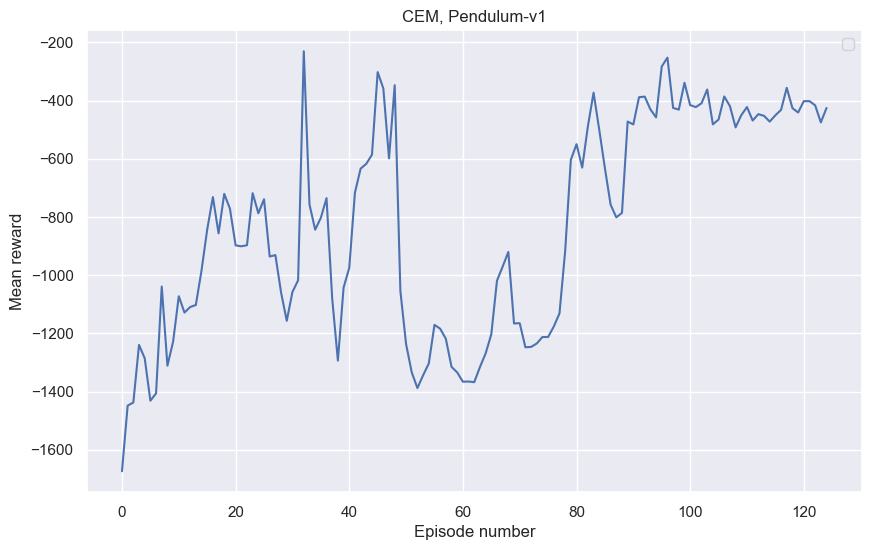

In [ ]:
plt.title('CEM, Pendulum-v1')
plt.xlabel('Episode number')
plt.ylabel('Mean reward')
plt.legend()

plt.plot(history)

Валидация:

**mean total reward on 100 validation trajectories: -441.301006123251**

In [ ]:
val_score = validation(env, agent)
print(f'mean total reward on 100 validation trajectories: {val_score}')

mean total reward on 100 validation trajectories: -441.301006123251


Из-за длительности обучения и нестабильности ограничимся только этим результатом:

Использую экспоненциальное сглаживание, преобразуем график истории обучения

In [14]:
h1 = np.load('cem_pendulum_history.npy')
h2 = np.load('cem_pendulum_history2.npy')

In [15]:
h1 = h1[:h2.size]

In [16]:
def get_plots(h1):

    h_smoothed1 = np.zeros_like(h1)

    alpha = 0.1
    h_smoothed1[0] = h1[0]

    for i in range(1, h_smoothed1.size):
        h_smoothed1[i] = alpha * h1[i] + (1 - alpha) * h_smoothed1[i - 1]

    h_smoothed1 = h_smoothed1.reshape(-1, 1)

    plt.plot(np.arange(h_smoothed1.size), h_smoothed1)

    plt.title('CEM, Pendulum-v1')
    plt.xlabel('Trajectory number')
    plt.ylabel('Trajectory reward')
    plt.legend()

    return h_smoothed1

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


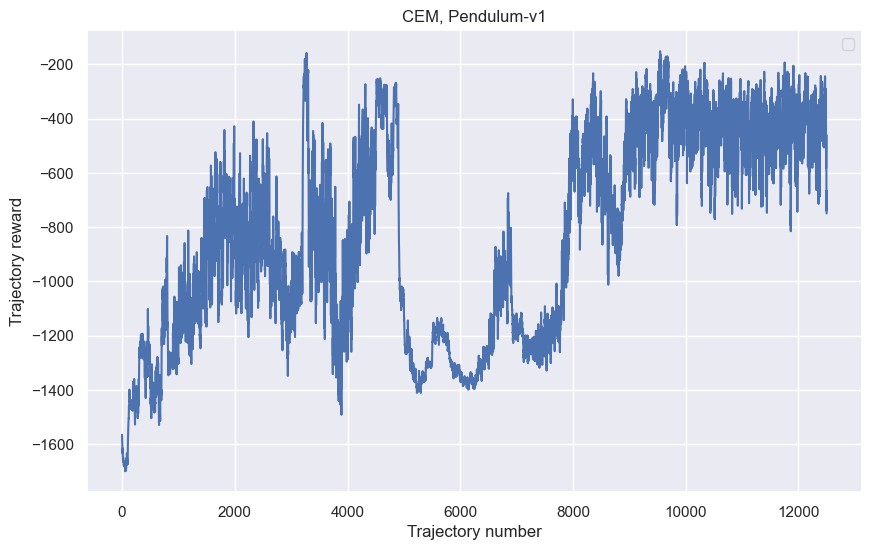

In [17]:
cem_history_smoothed = get_plots(h1)

При меньшем коэффиценте сглаживания награда в конце становится еще меньше. Поэтому ограничимся таким уровнем сглаживания.

### DQN


Задаем структуру аппроксимации $Q^\theta$, начальные вектор параметров $\theta$, вероятность исследования среды $\varepsilon = 1$.

Для каждого эпизода $k$ делаем:

Пока эпизод не закончен делаем:

- Находясь в состоянии $S_t$ совершаем действие $A_t \sim \pi(\cdot|S_t)$, где $\pi = \varepsilon\text{-greedy}(Q^\theta)$, получаем награду $R_t$  переходим в состояние $S_{t+1}$. Сохраняем $(S_t,A_t,R_t,S_{t+1}) \rightarrow Memory$


- Берем $\{(s_i,a_i,r_i,s'_i)\}_{i=1}^{n} \leftarrow Memory$, определяем целевые значения

$$
y_i =
\left\{
\begin{array}{ll}
r_i, &\text{ если } s'_i\text{ -терминальное},\\[0.0cm]
 r_i + \gamma \max\limits_{a'} Q^\theta(s'_i,a'), &\text{ иначе}
\end{array}
\right.
$$

функцию потерь $Loss(\theta) = \frac{1}{n}\sum\limits_{i=1}^n \big(y_i - Q^\theta(s_i,a_i)\big)^2$
и обновляем вектор параметров

$$
\theta \leftarrow \theta - \alpha \nabla_\theta Loss(\theta)
$$

- Уменьшаем $\varepsilon$


Для использования этого алгоритма в средах с непрерывным пространством действий воспользуемся дискретизацией. Договоримся, что агент может выполнять только 2 действия: -2 и 2. Функция get_action() агента будет выдавать номер действия (0 или 1). При создании траектории после использования функции get_action() будем преобразовывать ее вывод в действие -2 или 2 (0 переходит в -2, 1 в 2).

Реализация:

```python
...
actual_action = np.array([int(-2 + 4 * action)])
...

```

Реализация алгоритма:

In [5]:
class Qfunction(nn.Module):
    def __init__(self, state_dim, action_n):
        super().__init__()
        self.linear_1 = nn.Linear(state_dim, 512)
        self.linear_3 = nn.Linear(512, action_n)
        self.activation = nn.ReLU()

    def forward(self, states):
        hidden = self.linear_1(states)
        hidden = self.activation(hidden)
        actions = self.linear_3(hidden)
        return actions

In [6]:
class DQN():
    def __init__(self, state_dim, action_n, gamma=0.99, lr=1e-3, batch_size=64, epsilon_decrease=0.01, epilon_min=0.01):
        self.state_dim = state_dim
        self.action_n = action_n
        self.q_function = Qfunction(self.state_dim, self.action_n)
        self.gamma = gamma
        self.batch_size = batch_size
        self.epsilon = 1
        self.epsilon_decrease = epsilon_decrease
        self.epilon_min = epilon_min
        self.memory = []
        self.lr = lr
        self.optimizer = torch.optim.Adam(self.q_function.parameters(), lr=self.lr)

    def get_action(self, state):
        q_values = self.q_function(torch.FloatTensor(state))
        argmax_action = torch.argmax(q_values)
        probs = self.epsilon * np.ones(self.action_n) / self.action_n
        probs[argmax_action] += 1 - self.epsilon
        action = np.random.choice(np.arange(self.action_n), p=probs)
        return action
    
    def fit(self, state, action, reward, done, next_state, algo='default', hard_n=3, tau=0.9):
        self.memory.append([state, action, reward, int(done), next_state])

        if len(self.memory) > self.batch_size:
    
            if algo == 'default':

                batch = random.sample(self.memory, self.batch_size)
                states, actions, rewards, dones, next_states = map(torch.tensor, list(zip(*batch)))

                targets = rewards + self.gamma * (1 - dones) * torch.max(self.q_function(next_states), dim=1).values
                q_values = self.q_function(states)[torch.arange(self.batch_size), actions]
                loss = torch.mean((q_values - targets.detach()) ** 2)
                loss.backward()
                self.optimizer.step()
                self.optimizer.zero_grad()

            if algo == 'hard':

                theta_updating = self.q_function.state_dict()
                q_function_updating = Qfunction(self.state_dim, self.action_n)
                q_function_updating.load_state_dict(theta_updating, strict=False)
                
                optimizer_updating = torch.optim.Adam(q_function_updating.parameters(), lr=self.lr)

                for _ in range(hard_n):

                    batch = random.sample(self.memory, self.batch_size)
                    states, actions, rewards, dones, next_states = map(torch.tensor, list(zip(*batch)))

                    targets = rewards + self.gamma * (1 - dones) * torch.max(self.q_function(next_states), dim=1).values
                    q_values = q_function_updating(states)[torch.arange(self.batch_size), actions]
                    loss = torch.mean((q_values - targets.detach()) ** 2)
                    loss.backward()
                    optimizer_updating.step()
                    optimizer_updating.zero_grad()

                theta_new = q_function_updating.state_dict()
                self.q_function.load_state_dict(theta_new)

            if algo == 'soft':

                q_function_updating = Qfunction(self.state_dim, self.action_n)
                q_function_updating.load_state_dict(self.q_function.state_dict())
                optimizer_updating = torch.optim.Adam(q_function_updating.parameters(), lr=self.lr)

                batch = random.sample(self.memory, self.batch_size)
                states, actions, rewards, dones, next_states = map(torch.tensor, list(zip(*batch)))

                targets = rewards + self.gamma * (1 - dones) * torch.max(self.q_function(next_states), dim=1).values
                q_values = q_function_updating(states)[torch.arange(self.batch_size), actions]
                loss = torch.mean((q_values - targets.detach()) ** 2)
                loss.backward()
                optimizer_updating.step()
                optimizer_updating.zero_grad()

                theta_new = q_function_updating.state_dict()
                self.q_function.load_state_dict(theta_new)

                for param1, param2 in zip(self.q_function.parameters(), q_function_updating.parameters()):
                    param1.data = tau * param2.data + (1 - tau) * param1.data

            if algo == 'double':

                q_function_updating = Qfunction(self.state_dim, self.action_n)
                q_function_updating.load_state_dict(self.q_function.state_dict())
                optimizer_updating = torch.optim.Adam(q_function_updating.parameters(), lr=self.lr)

                batch = random.sample(self.memory, self.batch_size)
                states, actions, rewards, dones, next_states = map(torch.tensor, list(zip(*batch)))

                argument = torch.argmax(self.q_function(next_states), dim=1)
                argument = torch.LongTensor(argument)
                
                q_function_updating_values = torch.tensor(
                    [q_function_updating(next_states)[i, argument[i]] for i in range(len(batch))]
                )

                targets = rewards + self.gamma * (1 - dones) * q_function_updating_values
                q_values = q_function_updating(states)[torch.arange(self.batch_size), actions]
                loss = torch.mean((q_values - targets.detach()) ** 2)
                loss.backward()
                optimizer_updating.step()
                optimizer_updating.zero_grad()

                theta_new = q_function_updating.state_dict()
                self.q_function.load_state_dict(theta_new)

                for param1, param2 in zip(self.q_function.parameters(), q_function_updating.parameters()):
                    param1.data = tau * param2.data + (1 - tau) * param1.data
            
            if self.epsilon > self.epilon_min:
                self.epsilon -= self.epsilon_decrease

In [7]:
def get_trajectory(env, agent, trajectory_len, fit=False, algo='default', visualize=False, filename='gym_animation.gif'):
    trajectory = {'states':[], 'actions': [], 'total_reward': 0}
    
    state = env.reset()
    trajectory['states'].append(state)

    frames = []
    for _ in range(trajectory_len):

        action = agent.get_action(state)
        trajectory['actions'].append(action)

        actual_action = np.array([int(-2 + 4 * action)])

        next_state, reward, done, _ = env.step(actual_action)
        trajectory['total_reward'] += reward

        if fit == True:
            agent.fit(state, action, reward, done, next_state, algo)

        state = next_state

        if done:
            break

        if visualize:
            frames.append(env.render(mode="rgb_array"))

    if visualize:
        save_frames_as_gif(frames, filename=filename)

    return trajectory

In [8]:
def train(env, agent, episode_n, trajectory_len, algo='default'):
    rewards = []
    for episode in range(episode_n):
        trajectory = get_trajectory(env, agent, trajectory_len, fit=True, algo=algo)
        print(f"episode: {episode}, total_reward: {trajectory['total_reward']}")
        rewards.append(trajectory['total_reward'])

    return rewards

In [9]:
def validation(env, agent, trajectory_len, validation_n):
    total_rewards = []
    for _ in range(validation_n):
        trajectory = get_trajectory(env, agent, trajectory_len)
        total_rewards.append(trajectory['total_reward'])

    return np.mean(total_rewards)

Обучение: (5 мин)

Используется стандартная версия алгоритма (без Soft/Hard Target модификаций). Проблем связанных с автокорелляцией не возникает, поскольку функция наград непрерывна по состоянию для среду Pendulum-v1:

$$
r = - \left( \theta^2 + 0.1 \cdot \frac{\partial^2 \theta}{\partial t^2} + 0.001 \cdot u \right)
$$

Выбранные гиперпараметры:

```python
episode_n = 500
trajectory_len = 200

dqn_agent.lr = 1e-4
dqn_agent.epsilon_decrease = 0.005
```

In [10]:
action_n = 2

In [11]:
dqn_agent = DQN(state_dim, action_n)

In [12]:
episode_n = 500
trajectory_len = 200

In [13]:
dqn_agent.lr = 1e-4
dqn_agent.epsilon_decrease = 0.005

In [ ]:
dqn_rewards = train(env, dqn_agent, episode_n, trajectory_len, algo='default')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


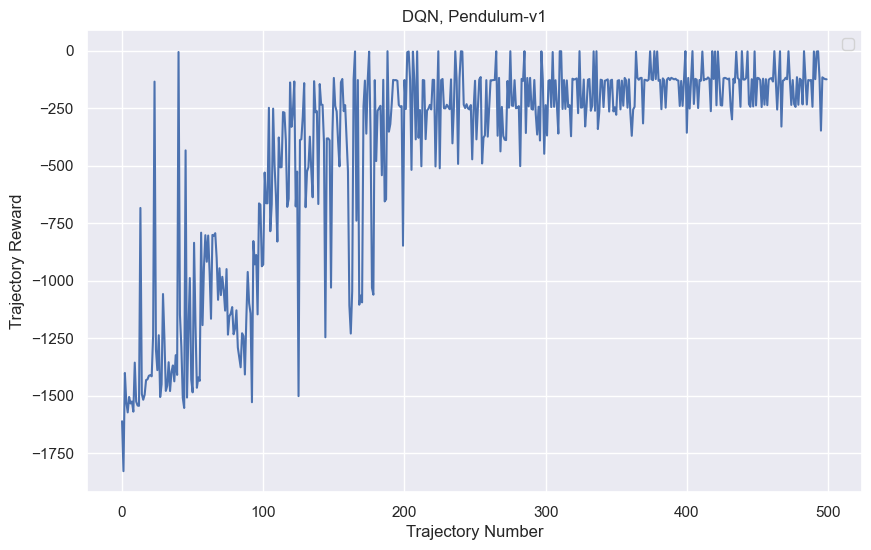

In [26]:
plt.title('DQN, Pendulum-v1')
plt.xlabel('Trajectory Number')
plt.ylabel('Trajectory Reward')
plt.legend()


plt.plot(dqn_rewards)

Валидация:

**DQN validation_score: -149.3915106810389**

In [ ]:
validation_n = 100
validation_score = validation(env, dqn_agent, validation_n=validation_n, trajectory_len=200)
print(f'DQN validation_score: {validation_score}')

Повторим еще 2 раза и построим сглаженный график:

In [20]:
h1 = np.load('dqn_history1.npy')
h2 = np.load('dqn_history2.npy')
h3 = np.load('dqn_history3.npy')

In [21]:
def get_plots(h1, h2, h3):

    h_smoothed1 = np.zeros_like(h1)
    h_smoothed2 = np.zeros_like(h1)
    h_smoothed3 = np.zeros_like(h1)

    alpha = 0.1
    h_smoothed1[0] = h1[0]
    h_smoothed2[0] = h2[0]
    h_smoothed3[0] = h3[0]

    for i in range(1, h_smoothed1.size):
        h_smoothed1[i] = alpha * h1[i] + (1 - alpha) * h_smoothed1[i - 1]
        h_smoothed2[i] = alpha * h2[i] + (1 - alpha) * h_smoothed2[i - 1]
        h_smoothed3[i] = alpha * h3[i] + (1 - alpha) * h_smoothed3[i - 1]


    h_smoothed1 = h_smoothed1.reshape(-1, 1)
    h_smoothed2 = h_smoothed2.reshape(-1, 1)
    h_smoothed3 = h_smoothed3.reshape(-1, 1)

    h_smoothed = np.concatenate((h_smoothed1, h_smoothed2, h_smoothed3), axis=1)
    h_smoothed_mean = np.mean(h_smoothed, axis=1)
    stds = np.std(h_smoothed, axis=1)

    plt.plot(np.arange(h_smoothed_mean.size), h_smoothed_mean)
    plt.fill_between(np.arange(h_smoothed_mean.size), h_smoothed_mean - stds, h_smoothed_mean + stds, alpha=0.5)

    plt.title('PPO, default advantage, Pendulum-v1')
    plt.xlabel('Trajectory number')
    plt.ylabel('Trajectory reward')
    plt.legend()

    return h_smoothed_mean, stds

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


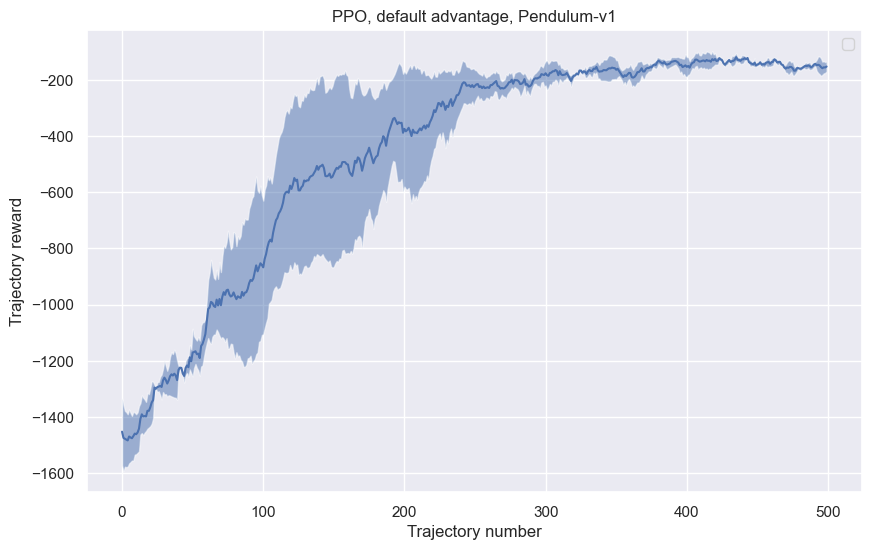

In [22]:
dqn_history_smoothed, dqn_std_smoothed = get_plots(h1, h2, h3)

Обучение проходит очень быстро, а результат получается на удивление хорошим!

### PPO


Задаем структуру аппроксимации $Q^\theta$, начальные вектор параметров $\theta$, вероятность исследования среды $\varepsilon = 1$.

Для каждого эпизода $k$ делаем:

Пока эпизод не закончен делаем:

- Находясь в состоянии $S_t$ совершаем действие $A_t \sim \pi(\cdot|S_t)$, где $\pi = \varepsilon\text{-greedy}(Q^\theta)$, получаем награду $R_t$  переходим в состояние $S_{t+1}$. Сохраняем $(S_t,A_t,R_t,S_{t+1}) \rightarrow Memory$


- Берем $\{(s_i,a_i,r_i,s'_i)\}_{i=1}^{n} \leftarrow Memory$, определяем целевые значения

$$
y_i =
\left\{
\begin{array}{ll}
r_i, &\text{ если } s'_i\text{ -терминальное},\\[0.0cm]
 r_i + \gamma \max\limits_{a'} Q^\theta(s'_i,a'), &\text{ иначе}
\end{array}
\right.
$$

функцию потерь $Loss(\theta) = \frac{1}{n}\sum\limits_{i=1}^n \big(y_i - Q^\theta(s_i,a_i)\big)^2$
и обновляем вектор параметров

$$
\theta \leftarrow \theta - \alpha \nabla_\theta Loss(\theta)
$$

- Уменьшаем $\varepsilon$


Реализация:

In [ ]:
class PPO(nn.Module):
    def __init__(self, state_dim, action_dim, gamma=0.9, batch_size=128, 
                 epsilon=0.2, epoch_n=30, pi_lr=1e-4, v_lr=5e-4):

        super().__init__()
        
        self.state_dim = state_dim
        self.action_dim = action_dim

        self.pi_model = nn.Sequential(nn.Linear(self.state_dim, 128), nn.ReLU(),
                                      nn.Linear(128, 128), nn.ReLU(),
                                      nn.Linear(128, 2 * self.action_dim), nn.Tanh())
        
        self.v_model = nn.Sequential(nn.Linear(self.state_dim, 128), nn.ReLU(),
                                     nn.Linear(128, 128), nn.ReLU(),
                                     nn.Linear(128, 1))
        
        self.gamma = gamma
        self.batch_size = batch_size
        self.epsilon = epsilon
        self.epoch_n = epoch_n
        self.pi_optimizer = torch.optim.Adam(self.pi_model.parameters(), lr=pi_lr)
        self.v_optimizer = torch.optim.Adam(self.v_model.parameters(), lr=v_lr)

    def get_action(self, state):
        mean, log_std = self.pi_model(torch.FloatTensor(state))
        dist = Normal(mean, torch.exp(log_std))
        action = dist.sample()
        return action.numpy().reshape(1)

    def fit(self, states, actions, rewards, dones, advantage='default'):
        
        states, actions, rewards, dones = map(np.array, [states, actions, rewards, dones])
        rewards, dones = rewards.reshape(-1, 1), dones.reshape(-1, 1)

        next_states = np.zeros_like(states)
        next_states[:-1] = states[1:]

        returns = np.zeros(rewards.shape)
        returns[-1] = rewards[-1]
        for t in range(returns.shape[0] - 2, -1, -1):
            returns[t] = rewards[t] + (1 - dones[t]) * self.gamma * returns[t + 1]

        states, next_states, actions, rewards, returns, dones = map(torch.FloatTensor, [states, next_states, actions, rewards, returns, dones])

        mean, log_std = self.pi_model(states).T
        mean, log_std = mean.unsqueeze(1), log_std.unsqueeze(1)
        dist = Normal(mean, torch.exp(log_std))
        old_log_probs = dist.log_prob(actions).detach()

        for epoch in range(self.epoch_n):
            
            idxs = np.random.permutation(returns.shape[0])
            for i in range(0, returns.shape[0], self.batch_size):
                b_idxs = idxs[i: i + self.batch_size]
                b_states = states[b_idxs]
                b_next_states = next_states[b_idxs]
                b_dones = dones[b_idxs]
                b_actions = actions[b_idxs]
                b_rewards = rewards[b_idxs]
                b_returns = returns[b_idxs]
                b_old_log_probs = old_log_probs[b_idxs]

                if advantage == 'default':
                    b_advantage = b_returns.detach() - self.v_model(b_states)

                if advantage == 'bellman':
                    b_advantage = b_rewards.detach() + (1 - b_dones.detach()) * self.gamma * self.v_model(b_next_states.detach()) - self.v_model(b_states) 

                if advantage == 'test':
                    b_advantage = b_rewards.detach() + (1 - b_dones.detach()) * self.gamma * self.v_model(b_next_states) - self.v_model(b_states) 

                b_mean, b_log_std = self.pi_model(b_states).T
                b_mean, b_log_std = b_mean.unsqueeze(1), b_log_std.unsqueeze(1)
                b_dist = Normal(b_mean, torch.exp(b_log_std))
                b_new_log_probs = b_dist.log_prob(b_actions)
    
                b_ratio = torch.exp(b_new_log_probs - b_old_log_probs)
                pi_loss_1 = b_ratio * b_advantage.detach()
                pi_loss_2 = torch.clamp(b_ratio, 1. - self.epsilon,  1. + self.epsilon) * b_advantage.detach()
                pi_loss = - torch.mean(torch.min(pi_loss_1, pi_loss_2))
                
                pi_loss.backward()
                self.pi_optimizer.step()
                self.pi_optimizer.zero_grad()
                
                v_loss = torch.mean(b_advantage ** 2)
    
                v_loss.backward()
                self.v_optimizer.step()
                self.v_optimizer.zero_grad()

In [ ]:
def get_trajectory(env, agent, trajectory_len=200, visualize=False, filename='gym_animation.gif'):
    trajectory = {'states':[], 'actions': [], 'rewards': [], 'dones': []}
    
    state = env.reset()

    frames = []
    for _ in range(trajectory_len):

        trajectory['states'].append(state)

        action = agent.get_action(state)
        trajectory['actions'].append(action)

        next_state, reward, done, _ = env.step(2 * action)
        trajectory['rewards'].append(reward)
        trajectory['dones'].append(done)

        state = next_state

        if done:
            break

        if visualize:
            frames.append(env.render(mode="rgb_array"))

    if visualize:
        save_frames_as_gif(frames, filename=filename)

    return trajectory

In [ ]:
def train(env, agent, episode_n=50, trajectory_n=20, trajectory_len=200, advantage='default'):
    total_rewards = []
    for episode in range(episode_n):

        states, actions, rewards, dones = [], [], [], []

        for i in range(trajectory_n):

            trajectory = get_trajectory(env, agent, trajectory_len)

            states.extend(trajectory['states'])
            actions.extend(trajectory['actions'])
            rewards.extend(trajectory['rewards'])
            dones.extend(trajectory['dones'])

            total_rewards.append(np.sum(trajectory['rewards']))

        print(f"{episode}: mean reward = {np.mean(total_rewards[-trajectory_n:])}")

        agent.fit(states, actions, rewards, dones, advantage)

    return total_rewards

In [ ]:
def validation(env, agent, validation_n, trajectory_len=200):
    total_rewards = []
    for _ in range(validation_n):
        trajectory = get_trajectory(env, agent, trajectory_len)
        total_rewards.append(np.sum(trajectory['rewards']))

    return np.mean(total_rewards)

Обучение: (4 мин)

Используется стандартная версия алгоритма для непрерывного одномерного пространства действий.

Для обучения были подобраны следующие гиперпараметры:

```python
episode_n = 25
trajectory_n = 20

gamma = 0.9
batch_size = 128 
epsilon = 0.2
epoch_n = 30 
pi_lr = 1e-4 
v_lr = 5e-4
```

Архитектуры нейронных сетей:

```python

self.pi_model = nn.Sequential(nn.Linear(self.state_dim, 128), nn.ReLU(),
                              nn.Linear(128, 128), nn.ReLU(),
                              nn.Linear(128, 2 * self.action_dim), nn.Tanh())

self.v_model = nn.Sequential(nn.Linear(self.state_dim, 128), nn.ReLU(),
                             nn.Linear(128, 128), nn.ReLU(),
                             nn.Linear(128, 1))

```

In [ ]:
ppo_default_agent = PPO(state_dim, action_dim)

In [ ]:
episode_n = 25
trajectory_n = 20

In [ ]:
ppo_default_history = []

In [ ]:
ppo_default_rewards = train(env, ppo_default_agent, episode_n, trajectory_n, advantage='default')

In [ ]:
ppo_default_history.extend(ppo_default_rewards)

График обучения:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


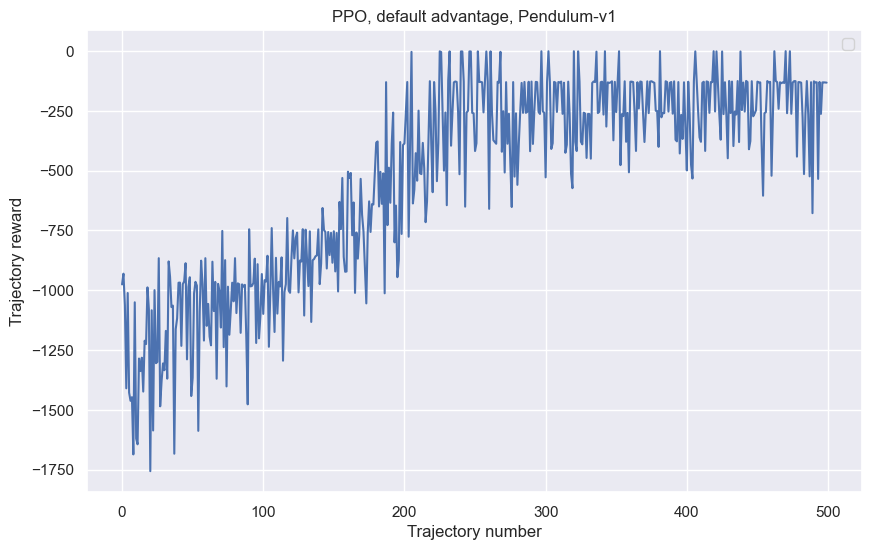

In [28]:
plt.title('PPO, default advantage, Pendulum-v1')
plt.xlabel('Trajectory number')
plt.ylabel('Trajectory reward')
plt.legend()

plt.plot(ppo_default_history)

Валидация:

**PPO, default advantage, validation_score: -252.77200815790158**

In [ ]:
validation_n = 100

validation_score = validation(env, ppo_default_agent, validation_n=validation_n, trajectory_len=200)
print(f'PPO, default advantage, validation_score: {validation_score}')

Повторим еще 2 раза и построим сглаженный график:

In [29]:
h1 = np.load('ppo_default_history1.npy')
h2 = np.load('ppo_default_history2.npy')
h3 = np.load('ppo_default_history3.npy')

In [30]:
def get_plots(h1, h2, h3):

    h_smoothed1 = np.zeros_like(h1)
    h_smoothed2 = np.zeros_like(h1)
    h_smoothed3 = np.zeros_like(h1)

    alpha = 0.1
    h_smoothed1[0] = h1[0]
    h_smoothed2[0] = h2[0]
    h_smoothed3[0] = h3[0]

    for i in range(1, h_smoothed1.size):
        h_smoothed1[i] = alpha * h1[i] + (1 - alpha) * h_smoothed1[i - 1]
        h_smoothed2[i] = alpha * h2[i] + (1 - alpha) * h_smoothed2[i - 1]
        h_smoothed3[i] = alpha * h3[i] + (1 - alpha) * h_smoothed3[i - 1]


    h_smoothed1 = h_smoothed1.reshape(-1, 1)
    h_smoothed2 = h_smoothed2.reshape(-1, 1)
    h_smoothed3 = h_smoothed3.reshape(-1, 1)

    h_smoothed = np.concatenate((h_smoothed1, h_smoothed2, h_smoothed3), axis=1)
    h_smoothed_mean = np.mean(h_smoothed, axis=1)
    stds = np.std(h_smoothed, axis=1)

    plt.plot(np.arange(h_smoothed_mean.size), h_smoothed_mean)
    plt.fill_between(np.arange(h_smoothed_mean.size), h_smoothed_mean - stds, h_smoothed_mean + stds, alpha=0.5)

    plt.title('PPO, default advantage, Pendulum-v1')
    plt.xlabel('Trajectory number')
    plt.ylabel('Trajectory reward')
    plt.legend()

    return h_smoothed_mean, stds

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


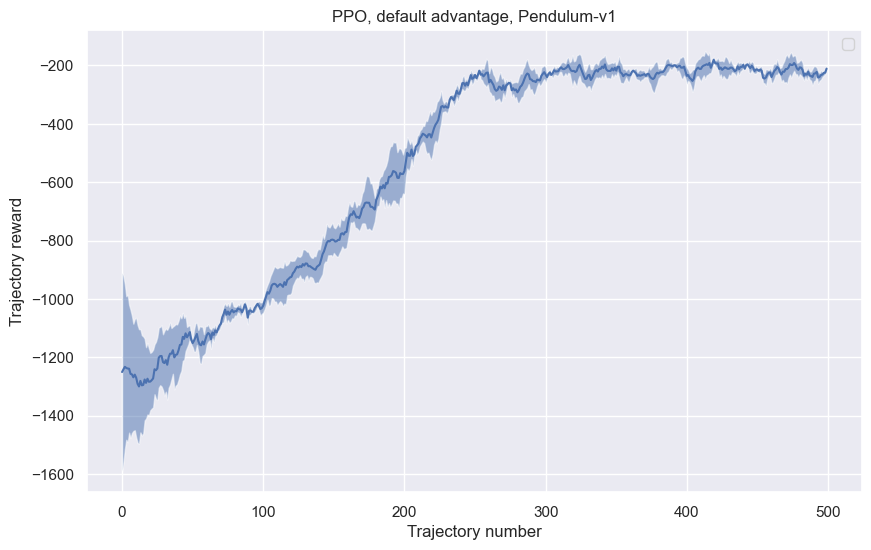

In [31]:
ppo_history_smoothed, ppo_std_smoothed = get_plots(h1, h2, h3)

### SAC

Инициализируем политику $ \pi^{\eta} $ и $ Q^{\theta_i}, \, Q^{\theta'_i} $ нейронными сетями. Далее на каждом эпизоде выполняем:

* Добавляем в буффер $ (S_t, A_t, R_t, D_t, S_{t+1}) \rightarrow M $

* Достаем батч из буффера $ \{ (s_j, a_j, r_j, d_j, s'_j) \}^n \leftarrow M $, 

$$
y_j = r_j + \gamma (1 - d_j) \left( \min_{i=1,2} Q^{\theta'_i} (s'_j, a'_j) - \alpha log \pi (a'_j | s'_j)  \right)
$$

Определяем лосс функции:

$$
L_i(\theta_i) = \frac{1}{n} \sum_{j=1}^{n} (y_j - Q^{\theta_i} (s_j, a_j))^2
$$

$$
L_3(\eta) = \frac{1}{n} \sum_{j=1}^{n} ( \min_{i=1,2} Q^{\theta_i} (s_j, a^{\eta}_j) - \alpha log \pi^{\eta} (a^{\eta}_j | s_j))
$$

И обновляем параметры градиентным спуском.

Реализация:

In [ ]:
class SAC(nn.Module):
    def __init__(self, state_dim, action_dim, gamma=0.99, alpha=1e-3, tau=1e-2, 
                 batch_size=64, pi_lr=1e-3, q_lr=1e-3):
        super().__init__()

        self.pi_model = nn.Sequential(nn.Linear(state_dim, 128), nn.ReLU(), 
                                      nn.Linear(128, 128), nn.ReLU(), 
                                      nn.Linear(128, 2 * action_dim), nn.Tanh())

        self.q1_model = nn.Sequential(nn.Linear(state_dim + action_dim, 128), nn.ReLU(), 
                                      nn.Linear(128, 128), nn.ReLU(), 
                                      nn.Linear(128, 1))

        self.q2_model = nn.Sequential(nn.Linear(state_dim + action_dim, 128), nn.ReLU(), 
                                      nn.Linear(128, 128), nn.ReLU(), 
                                      nn.Linear(128, 1))

        self.gamma = gamma
        self.alpha = alpha
        self.tau = tau
        self.batch_size = batch_size
        self.memory = []

        self.softmax = nn.Softmax()

        self.pi_optimizer = torch.optim.Adam(self.pi_model.parameters(), pi_lr)
        self.q1_optimizer = torch.optim.Adam(self.q1_model.parameters(), q_lr)
        self.q2_optimizer = torch.optim.Adam(self.q2_model.parameters(), q_lr)

        self.q1_target_model = deepcopy(self.q1_model)
        self.q2_target_model = deepcopy(self.q2_model)


    def get_action(self, state):
        state = torch.FloatTensor(state).unsqueeze(0)
        action, _ = self.predict_actions(state)
        return action.squeeze(1).detach().numpy()


    def fit(self, state, action, reward, done, next_state):
        self.memory.append([state, action, reward, done, next_state])

        if len(self.memory) > self.batch_size:
            batch = random.sample(self.memory, self.batch_size)
            states, actions, rewards, dones, next_states = map(torch.FloatTensor, zip(*batch))
            rewards, dones = rewards.unsqueeze(1), dones.unsqueeze(1)

            next_actions, next_log_probs = self.predict_actions(next_states)
            
            next_states_and_actions = torch.concatenate((next_states, next_actions), dim=1)
            next_q1_values = self.q1_target_model(next_states_and_actions)
            next_q2_values = self.q2_target_model(next_states_and_actions)
            next_min_q_values = torch.min(next_q1_values, next_q2_values)
            targets = rewards + self.gamma * (1 - dones) * (next_min_q_values - self.alpha * next_log_probs)

            states_and_actions = torch.concatenate((states, actions), dim=1)
            q1_loss = torch.mean((self.q1_model(states_and_actions) - targets.detach()) ** 2)
            q2_loss = torch.mean((self.q2_model(states_and_actions) - targets.detach()) ** 2)
            self.update_model(q1_loss, self.q1_optimizer, self.q1_model, self.q1_target_model)
            self.update_model(q2_loss, self.q2_optimizer, self.q2_model, self.q2_target_model)

            pred_actions, log_probs = self.predict_actions(states)
            states_and_pred_actions = torch.concatenate((states, pred_actions), dim=1)
            q1_values = self.q1_model(states_and_pred_actions)
            q2_values = self.q2_model(states_and_pred_actions)
            min_q_values = torch.min(q1_values, q2_values)
            pi_loss = - torch.mean(min_q_values - self.alpha * log_probs)
            self.update_model(pi_loss, self.pi_optimizer)
            
    def update_model(self, loss, optimizer, model=None, target_model=None):
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        if model != None and target_model != None:
            for param, terget_param in zip(model.parameters(), target_model.parameters()):
                new_terget_param = (1 - self.tau) * terget_param + self.tau * param
                terget_param.data.copy_(new_terget_param)

    def predict_actions(self, states):
        means, log_stds = self.pi_model(states).T
        means, log_stds = means.unsqueeze(1), log_stds.unsqueeze(1)
        dists = Normal(means, torch.exp(log_stds))
        actions = dists.rsample()
        log_probs = dists.log_prob(actions)

        return actions, log_probs

In [ ]:
def get_trajectory(env, agent, trajectory_len=200, visualize=False, filename='gym_animation.gif'):
    trajectory = {'states':[], 'actions': [], 'rewards': [], 'dones': []}
    
    state = env.reset()

    frames = []
    for _ in range(trajectory_len):

        trajectory['states'].append(state)

        action = agent.get_action(state)
        trajectory['actions'].append(action)

        next_state, reward, done, _ = env.step(action)
        trajectory['rewards'].append(reward)
        trajectory['dones'].append(done)

        state = next_state

        if done:
            break

        if visualize:
            frames.append(env.render(mode="rgb_array"))

    if visualize:
        save_frames_as_gif(frames, filename=filename)

    return trajectory

In [ ]:
def validation(env, agent, validation_n, trajectory_len=200):
    total_rewards = []
    for _ in range(validation_n):
        trajectory = get_trajectory(env, agent, trajectory_len)
        total_rewards.append(np.sum(trajectory['rewards']))

    return np.mean(total_rewards)

In [ ]:
def train(env, agent, episode_n, trajectory_len=200):
    total_rewards = []
    for episode in range(episode_n):

        total_reward = 0
        state = env.reset()
        
        for t in range(trajectory_len):
            action = agent.get_action(state)
            next_state, reward, done, _ = env.step(action)
        
            agent.fit(state, action, reward, done, next_state)

            total_reward += reward
            state = next_state

        total_rewards.append(total_reward)

    return total_rewards

Обучение: (6 мин)

Выбранные гиперпараметры:

```python
episode_n = 200

gamma=0.99 
alpha=1e-3
tau=1e-2
batch_size=64
pi_lr=1e-3
q_lr=1e-3
```

Архитектуры нейронный сетей:


```python

self.pi_model = nn.Sequential(nn.Linear(state_dim, 128), nn.ReLU(), 
                              nn.Linear(128, 128), nn.ReLU(), 
                              nn.Linear(128, 2 * action_dim), nn.Tanh())

self.q1_model = nn.Sequential(nn.Linear(state_dim + action_dim, 128), nn.ReLU(), 
                              nn.Linear(128, 128), nn.ReLU(), 
                              nn.Linear(128, 1))

self.q2_model = nn.Sequential(nn.Linear(state_dim + action_dim, 128), nn.ReLU(), 
                              nn.Linear(128, 128), nn.ReLU(), 
                              nn.Linear(128, 1))

```

In [ ]:
agent = SAC(state_dim, action_n)

In [ ]:
episode_n = 200

In [ ]:
sac_history = train(env, agent, episode_n)

График обучения:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


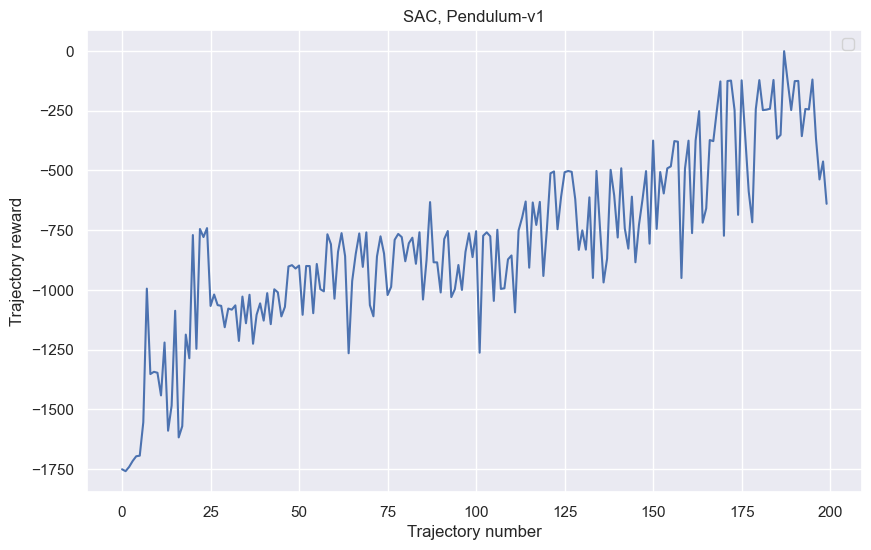

In [34]:
plt.title('SAC, Pendulum-v1')
plt.xlabel('Trajectory number')
plt.ylabel('Trajectory reward')
plt.legend()

plt.plot(sac_history)

Валидация:

**SAC, validation_score: -235.55826693948117**

In [ ]:
validation_n = 100

validation_score = validation(env, agent, validation_n=validation_n, trajectory_len=200)
print(f'SAC, default advantage, validation_score: {validation_score}')

Повторим еще 2 раза и построим сглаженный график:

In [35]:
h1 = np.load('sac_history1.npy')
h2 = np.load('sac_history2.npy')
h3 = np.load('sac_history3.npy')

In [36]:
def get_plots(h1, h2, h3):

    h_smoothed1 = np.zeros_like(h1)
    h_smoothed2 = np.zeros_like(h1)
    h_smoothed3 = np.zeros_like(h1)

    alpha = 1
    h_smoothed1[0] = h1[0]
    h_smoothed2[0] = h2[0]
    h_smoothed3[0] = h3[0]

    for i in range(1, h_smoothed1.size):
        h_smoothed1[i] = alpha * h1[i] + (1 - alpha) * h_smoothed1[i - 1]
        h_smoothed2[i] = alpha * h2[i] + (1 - alpha) * h_smoothed2[i - 1]
        h_smoothed3[i] = alpha * h3[i] + (1 - alpha) * h_smoothed3[i - 1]

    h_smoothed1 = h_smoothed1.reshape(-1, 1)
    h_smoothed2 = h_smoothed2.reshape(-1, 1)
    h_smoothed3 = h_smoothed3.reshape(-1, 1)

    h_smoothed = np.concatenate((h_smoothed1, h_smoothed2, h_smoothed3), axis=1)
    h_smoothed_mean = np.mean(h_smoothed, axis=1)
    stds = np.std(h_smoothed, axis=1)

    plt.plot(np.arange(h_smoothed_mean.size), h_smoothed_mean)
    plt.fill_between(np.arange(h_smoothed_mean.size), h_smoothed_mean - stds, h_smoothed_mean + stds, alpha=0.5)

    plt.title('SAC, Pendulum-v1')
    plt.xlabel('Trajectory number')
    plt.ylabel('Trajectory reward')
    plt.legend()

    return h_smoothed_mean, stds

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


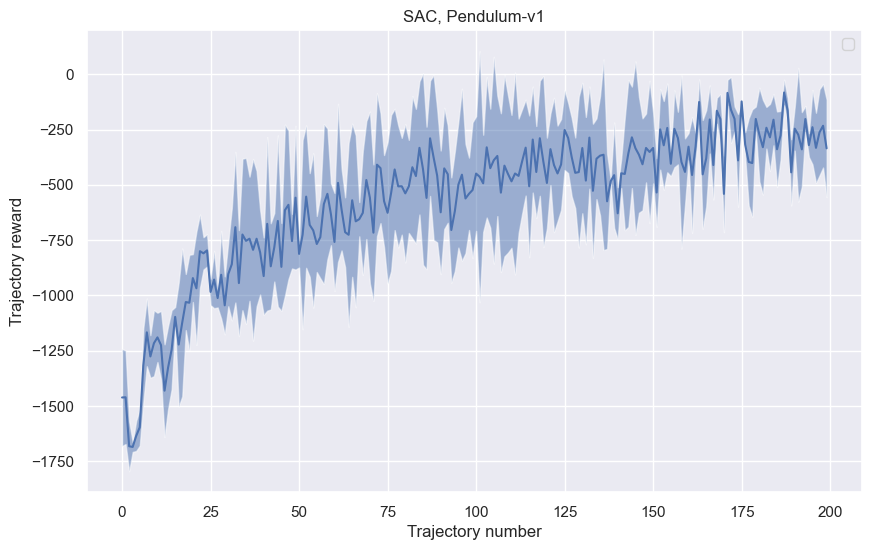

In [37]:
sac_history_smoothed, sac_std_smoothed = get_plots(h1, h2, h3)

## Полученные результаты:

Уже понятно, что CEM использует сильно больше траекторий. Изобразим кривые обучения DQN, PPO и SAC на одном графике:

In [38]:
def plot_results():

    plt.plot(np.arange(dqn_history_smoothed.size), dqn_history_smoothed, label='DQN')
    plt.fill_between(np.arange(dqn_history_smoothed.size),
                     dqn_history_smoothed - dqn_std_smoothed, 
                     dqn_history_smoothed + dqn_std_smoothed, alpha=0.4)

    plt.plot(np.arange(ppo_history_smoothed.size), ppo_history_smoothed, label='PPO')
    plt.fill_between(np.arange(ppo_history_smoothed.size),
                     ppo_history_smoothed - ppo_std_smoothed, 
                     ppo_history_smoothed + ppo_std_smoothed, alpha=0.4)

    plt.plot(np.arange(sac_history_smoothed.size), sac_history_smoothed, label='SAC')
    plt.fill_between(np.arange(sac_history_smoothed.size),
                     sac_history_smoothed - sac_std_smoothed, 
                     sac_history_smoothed + sac_std_smoothed, alpha=0.4)


    plt.title('Algorithm comparison, Pendulum-v1')
    plt.xlabel('Trajectory number')
    plt.ylabel('Trajectory reward')
    plt.legend()

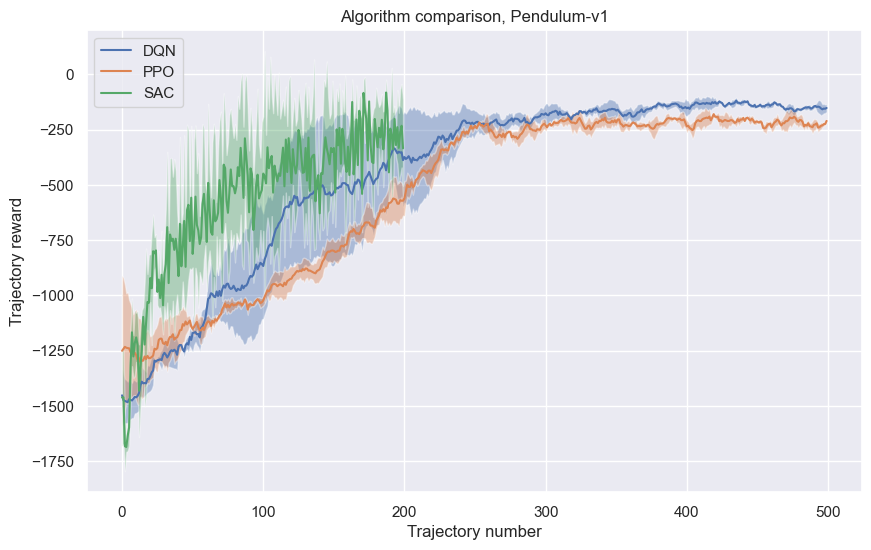

In [39]:
plot_results()

### **Вывод:**

Наилучшим алгоритмом по результату на валидации оказался стандартный DQN, использующий 2 действия: -2 и 2 из отрезка [-2, 2]. Результат на валидации алгоритма DQN оказался -150.

Алгоритмы PPO и SAC показывают значение на валидации не больше -200 независимо от количества эпизодов обучения. Возможно для улучшения этого результата следует аналогично сделать пространство действий дискретным, оставив 2 значения (-2 и 2). В свою очередь моя реализация CEM использует эту идею дискретизации действий, однако обучается хуже и получает значение на валидации не выше -400.

По времени обучения лидируют алгоритмы DQN и PPO, обучаясь по 5 минут. Однако SAC не сильно отстает и обучается за 6-7 минут. Обучение CEM для получения указанного выше результата занимает 30 минут.

Алгоритму SAC требуется наименьшее количество сгенерированных траекторий для успешного обучения - всего 200 штук. DQN и PPO используют по 500 траекторий. CEM потребовал 12500 траекторий, однако это связано со спецификой алгоритма. CEM является эволюционным алгоритмом и не задействует всего того теоретического аппарата $ Q $-функций и Policy Gradient теорем, которые задействуют другие алгоритмы.